In [264]:
import pandas as pd
import FinanceDataReader as fdr
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Import Data/Preprocess

In [10]:
NO_KOS_CODES = ['003340']  # 코스피, 코스닥 종목이 아닌 것

In [3]:
def split_reporter(s):
    s_splited = s.split()
    if len(s_splited) == 1:
        return s_splited[0], 'None'
    elif len(s_splited) == 2:
        return s_splited[0], s_splited[1]
    else:
        return s_splited[0], ' '.join(s_splited[1:])

In [435]:
def preprocess(df):
    df['company'] = df.apply(lambda x:x['titles'].split(' A')[0].strip(), axis=1)
    df['codes'] = df.apply(lambda x:x['titles'].split(' A')[1].split('-')[0].strip(), axis=1)
    df['report_company'] = df.apply(lambda x:split_reporter(x['reporter'])[0], axis=1)
    df['report_name'] = df.apply(lambda x:split_reporter(x['reporter'])[1], axis=1)
    df = df.drop(columns=['titles'])
    df = df[~df['codes'].isin(NO_KOS_CODES)]
    df = df.drop_duplicates(subset=['price_goal', 'reporter', 'dates', 'codes'], keep='first').reset_index(drop=True)
    df['price_goal'] = df['price_goal'].str.replace(',', '').astype(float)
    df['dates'] = pd.to_datetime(df['dates'])
    df['year_month'] = df['dates'].dt.year.astype(str) + df['dates'].dt.month.astype(str).str.zfill(2)
    return df

In [436]:
df = pd.read_csv('data/report_220101_221231.csv')
df = pd.concat([df, pd.read_csv('data/report_230101_230531.csv')])

In [437]:
df = preprocess(df)

### EDA

In [591]:
dfs = []
dfs_dict = {}
for code in tqdm(codes):
    df_stock = pd.read_csv(f'data_stock/{code}.csv')
    df_stock['Date'] = pd.to_datetime(df_stock['Date'])
    dfs.append(df_stock)
    dfs_dict[code] = df_stock

100%|██████████| 1504/1504 [00:03<00:00, 438.24it/s]


#### Selected

In [592]:
N_LATER = [0, 1, 5, 10, 20, 50]

In [593]:
data_list = []
for row in tqdm(range(len(df))):
    code, date = df.loc[row, 'codes'], df.loc[row, 'dates']
    df_stock = dfs_dict[code]
    df_stock_target = df_stock[df_stock['Date'] >=date].reset_index(drop=True)
    max_n = len(df_stock_target)
    data = {}
    for n in N_LATER:
        if n == 1:
            if n < max_n:
                data[f'{n}_Open'] = df_stock_target.loc[n]['Open']
            else:
                data[f'{n}_Open'] = 0
        if n < max_n:
            data[f'{n}_Close'] = df_stock_target.loc[n]['Close']
        else:
            data[f'{n}_Close'] = -1
    data_list.append(data)

100%|██████████| 30137/30137 [00:52<00:00, 569.09it/s]


In [594]:
df_ = pd.DataFrame(data_list)
df_concat = pd.concat([df, df_], axis=1)
df_concat['price_goal_ratio'] = df_concat['price_goal'] / df_concat['0_Close'] - 1

In [659]:
n = 20
th = 0.8

In [660]:
df_target = df_concat[df_concat[f'1_Open'] != 0].reset_index(drop=True)
df_target = df_target[df_target[f'{n}_Close'] != -1].reset_index(drop=True)

In [661]:
df_target['ratio'] = df_target[f'{n}_Close'] / df_target['1_Open'] - 1

In [662]:
df_go = df_target[df_target['price_goal_ratio'] > th]

In [663]:
print(df_target['ratio'].mean(), df_go['ratio'].mean())

-0.0009520029216811403 0.014959631873467931


In [664]:
print(len(df_target), len(df_go))

28461 1005


#### random

In [655]:
n = 50
count = 46
btst = []
for i in tqdm(range(300)):
    ratio_list = []
    for j in range(count+500):
        code_idx = np.random.choice(len(codes))
        df_stock = dfs[code_idx]
        start_max = len(df_stock)-n
        if start_max > 0:  # 최근 상장된 것들은 리포트는 있지만, later를 구할수가없음
            start_date = np.random.choice(range(start_max))
            if df_stock.loc[start_date, 'Open'] > 0:  # 거래정지의 경우 Open이 0임..
                end_date = start_date+n
                ratio = df_stock.loc[end_date, 'Close'] / df_stock.loc[start_date, 'Open'] - 1
                ratio_list.append(ratio)
    btst.append(np.mean(ratio_list[:count]))
    

100%|██████████| 300/300 [00:10<00:00, 29.24it/s]


In [656]:
sum(np.array(btst) > 0.054)

20

In [657]:
np.mean(np.array(btst))

-0.0008859651021176194

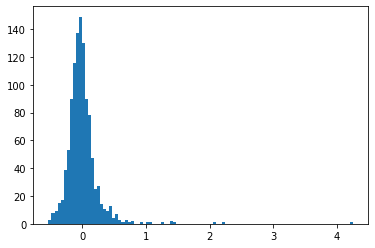

In [634]:
plt.hist(ratio_list, bins=100);

In [635]:
df_go.groupby('year_month').count()['ratio']

year_month
202201    477
202202    445
202203    259
202204    321
202205    499
202206    221
202207    497
202208    393
202209    234
202210    612
202211    597
202212     67
202301    244
202302    223
202303    127
202304    257
202305    232
Name: ratio, dtype: int64

In [636]:
df_go.groupby('year_month').mean()['ratio']

year_month
202201   -0.022231
202202    0.011584
202203    0.023445
202204   -0.018212
202205   -0.007490
202206   -0.046728
202207    0.034620
202208   -0.009976
202209   -0.050224
202210    0.026888
202211    0.026625
202212   -0.011090
202301    0.039252
202302   -0.007368
202303    0.045206
202304    0.006512
202305    0.002022
Name: ratio, dtype: float64

In [637]:
def get_info(df, gb_col='reporter'):
    df_mean = df.groupby(gb_col).mean()['ratio']
    df_count = df.groupby(gb_col).count()['ratio']
    df_result = pd.concat([df_count, df_mean], axis=1)
    df_result.columns = ['count', 'mean']
    return df_result.sort_values('mean', ascending=False)

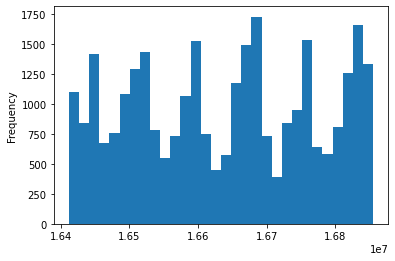

In [638]:
(pd.to_datetime(df['dates']).astype(int)/100000000000).plot(kind='hist', bins=30)

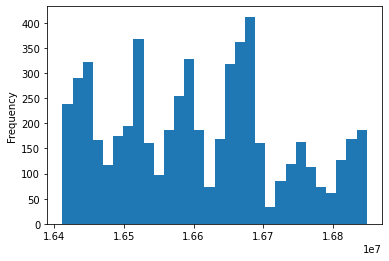

In [639]:
(pd.to_datetime(df_go['dates']).astype(int)/100000000000).plot(kind='hist', bins=30)

In [665]:
df_result = get_info(df_go, 'report_company')

In [666]:
df_result

,count,mean
report_company,,
DS투자증권,2,0.274151
현대차증권,52,0.052569
BNK투자증권,8,0.052075
메리츠증권,40,0.038932
한국투자증권,32,0.036529
NH투자증권,41,0.035833
유진투자증권,60,0.034682
삼성증권,24,0.033868
대신증권,60,0.028449


In [254]:
df_go['report_company'].unique()

array(['유진투자증권', 'KB증권', '유안타증권', 'DB금융투자', '신영증권', '하이투자증권', '상상인증권',
       '한화투자증권', '한국투자증권', '하나증권', '이베스트투자증권', '케이프투자증권', '대신증권',
       'NH투자증권', '미래에셋증권', '삼성증권', '신한투자증권', '밸류파인더', '키움증권', 'BNK투자증권',
       'IBK투자증권', '현대차증권', '흥국증권', '다올투자증권', '메리츠증권', '부국증권', '카카오페이증권',
       '교보증권', '한국금융분석원', 'DS투자증권', 'SK증권', '리딩투자증권', '한양증권', 'CTT리서치',
       '유화증권'], dtype=object)

In [274]:
df_go['invest_opinion'].unique()

array(['BUY', '매수', 'HOLD', '중장기주가상승', 'MARKETPERFORM', 'NEUTRAL', nan,
       'TRADING BUY', 'STRONG BUY', '중립', 'OUTPERFORM', '단기주가보합', '보유',
       '단기주가상승', '적극매수'], dtype=object)

In [273]:
df_go['invest_opinion'].unique()

,invest_opinion,price_goal,reporter,contents,dates,company,codes,report_company,report_name,0_Close,1_Open,1_Close,5_Close,10_Close,20_Close,50_Close,price_goal_ratio,ratio
0,BUY,160000.0,유진투자증권 이승우,4분기 영업이익 4.2조원 예상\n- 시안 봉쇄로 메모리 업황에 변수 발생,2022/01/03,SK하이닉스,000660,유진투자증권,이승우,75700,75600,75600,86000,85800,91400,79000,1.113606,0.208995
1,BUY,300000.0,KB증권 강승건,"투자의견 Buy, 목표주가 300,000원으로 직전대비 4.8% 하향\n- 4Q21...",2022/01/03,삼성화재,000810,KB증권,강승건,194500,196500,194000,201500,200500,208000,212500,0.542416,0.058524
2,BUY,106000.0,유안타증권 이재윤,"4Q21 영업이익 1,366억원으로 컨센서스 대폭 상회할 전망\n- 22년 연간 영...",2022/01/03,DB하이텍,000990,유안타증권,이재윤,36600,36300,37500,43100,43450,44950,47150,1.896175,0.238292
5,BUY,300000.0,DB금융투자 김평모,22년 물량 회복 전망\n- 22년까지 지속될 신차 효과,2022/01/03,현대차,005380,DB금융투자,김평모,157000,158500,159000,164000,166500,170000,174000,0.910828,0.072555
9,매수,13500.0,신영증권 서정연,GKL 카지노 입점 확정\n- 카지노 효과 기대,2022/01/03,서부T&D,006730,신영증권,서정연,7380,7480,7420,7800,7920,7970,7050,0.829268,0.065508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28411,BUY,110000.0,유진투자증권 정의훈,"1분기 매출액 644억원, 영업이익 8억원. 당사 매출 추정치(574억원)과 영업이...",2023/05/10,인텔리안테크,189300,유진투자증권,정의훈,72606,73477,72800,73865,72800,68500,-1,0.515026,-0.067735
28412,BUY,44000.0,흥국증권 최종경,"1Q23 Review: 영업수익 +11%, 영업이익 +21% YoY\n- 시장의 기...",2023/05/10,롯데렌탈,089860,흥국증권,최종경,27500,27700,27550,27200,27700,29000,-1,0.600000,0.046931
28426,BUY,86000.0,대신증권 유정현,백화점부문 대전점 영업중단 영향 제거 시 1분기 영업이익 약 2% 증가\n- 면세점...,2023/05/10,현대백화점,069960,대신증권,유정현,52400,52600,52200,52200,52500,51900,-1,0.641221,-0.013308
28435,BUY,140000.0,대신증권 박혜진,컨센서스 +50% 이상 상회하는 어닝서프라이즈 달성\n- 거래대금 반등 효과 가장 ...,2023/05/10,키움증권,039490,대신증권,박혜진,91000,91600,93300,94500,96000,96000,-1,0.538462,0.048035


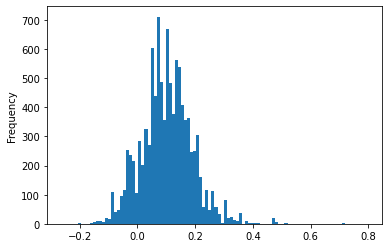

In [272]:
df_go['ratio'].plot(kind='hist', bins=100)

### workspace

In [580]:
codes = df['codes'].unique()

In [581]:
# fdr에서 데이터 local로 다운로드
for code in tqdm(codes):
    df_stock = fdr.DataReader(code, '2022', '2024')
    df_stock.to_csv(f'data_stock/{code}.csv')

100%|██████████| 1504/1504 [03:27<00:00,  7.26it/s]
